C:\Users\hskma\AppData\Local\Temp\ipykernel_3384\2214858925.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, pd.DataFrame([row])], ignore_index=True)
C:\Users\hskma\AppData\Local\Temp\ipykernel_3384\2214858925.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, pd.DataFrame([row])], ignore_index=True)
C:\Users\hskma\AppData\Local\Temp\ipykernel_3384\2214858925.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

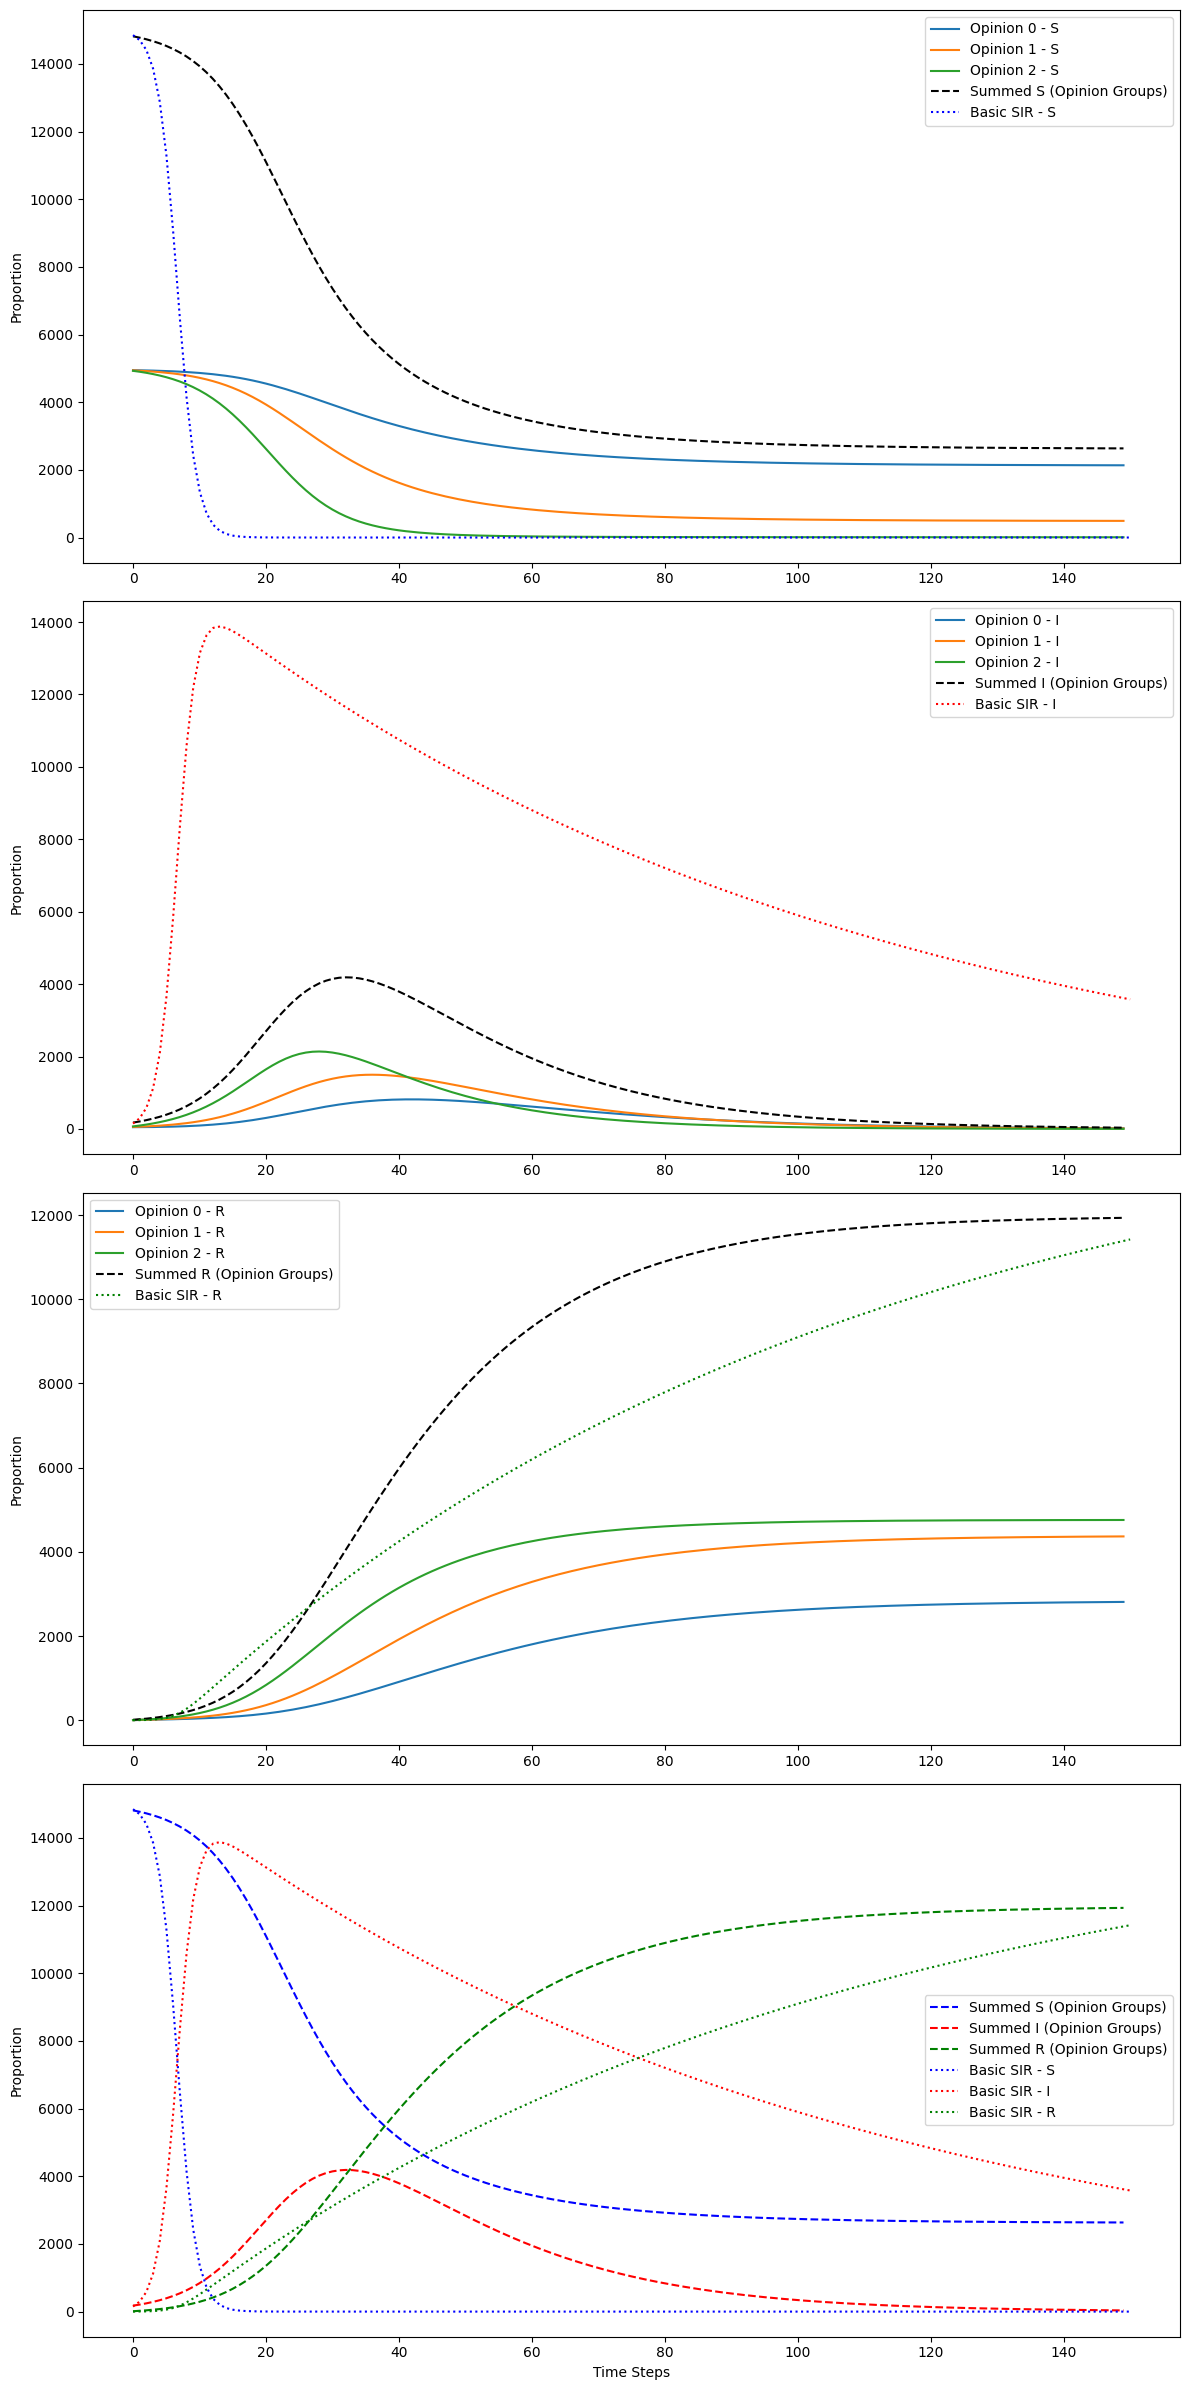

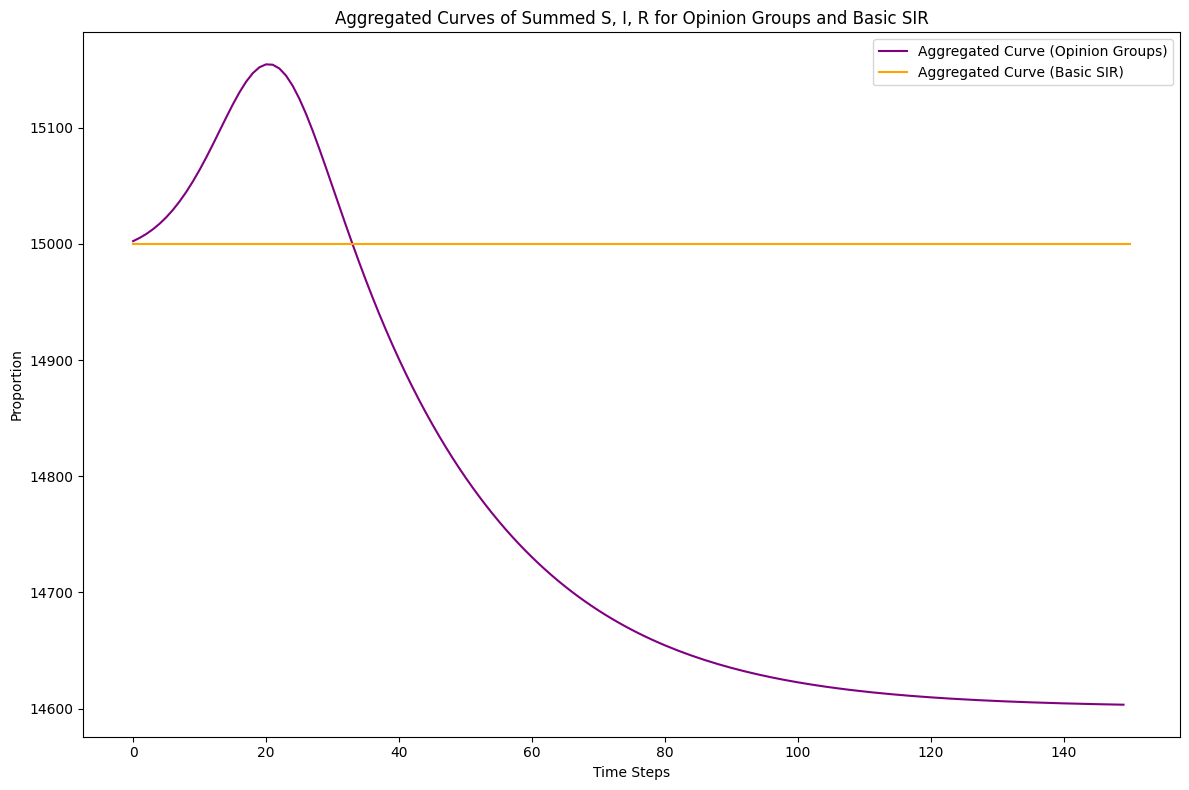

Optimized beta: 0.7
Optimized gamma: 0.01


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize

# Basic SIR model parameters and initial values
N = 15000
int_I = 0.01 * N
int_R = 0
int_S = N - int_I - int_R  # S_0 is starting susceptible
beta = 0.7
gamma = 0.01
MaxTime = 150
RunTime = np.linspace(0, MaxTime, MaxTime)

# Define the system of differential equations for the basic SIR model
def Find_Deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = (beta * S * I / N) - (gamma * I)
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions for the basic SIR model
y_0 = int_S, int_I, int_R

# Integrate the system of differential equations for the basic SIR model
coord = odeint(Find_Deriv, y_0, RunTime, args=(N, beta, gamma))
basic_S, basic_I, basic_R = coord.T

# Number of opinion groups (indexed from 0 to n), which can be changed accordingly if needed
n = 2  # The total number of opinion groups

# Below is the function to calculate the probability distribution over the opinions
def pi(q, n):
    return np.exp(q) / np.sum(np.exp(np.arange(n + 1)))

# Initialization of initial values for all the S, I, R in each opinion group
initial_values = {f'P_S_{i}': float(int_S / (n + 1)) for i in range(n + 1)}
initial_values.update({f'P_I_{i}': float(int_I / (n + 1)) for i in range(n + 1)})
initial_values.update({f'P_R_{i}': float(int_R / (n + 1)) for i in range(n + 1)})

# Differential equations for the SIR model with opinions
def dS(row, O, beta, N, n):
    return -pi(O, n) * beta * row[f'P_S_{O}'] * sum(row[f'P_I_{j}'] for j in range(n + 1)) / N

def dI(row, O, beta, gamma, N, n):
    return pi(O, n) * beta * row[f'P_S_{O}'] * sum(row[f'P_I_{j}'] for j in range(n + 1)) / N - (3 * n) * gamma * row[f'P_I_{O}']

def dR(row, O, gamma, n):
    return (3 * n) * gamma * row[f'P_I_{O}']

# Runge-Kutta method for solving differential equations
def runge(f, y0, row, *args):
    h = 1.0  # Step size for the Runge-Kutta method
    k1 = f(row, *args)
    k2 = f(row, *args)
    return y0 + h * k2

# Functions to update the proportions of S, I, and R in each opinion group
def update_proportions_S(row, beta, N, n):
    for i in range(n + 1):
        row[f'P_S_{i}'] = runge(dS, row[f'P_S_{i}'], row, i, beta, N, n)
    return row

def update_proportions_I(row, beta, gamma, N, n):
    for i in range(n + 1):
        row[f'P_I_{i}'] = runge(dI, row[f'P_I_{i}'], row, i, beta, gamma, N, n)
    return row

def update_proportions_R(row, gamma, n):
    for i in range(n + 1):
        row[f'P_R_{i}'] = runge(dR, row[f'P_R_{i}'], row, i, gamma, n)
    return row

# Main simulation function
def run_simulation(initial_values, beta, gamma, steps, N, n):
    columns = [f'P_S_{i}' for i in range(n + 1)] + [f'P_I_{i}' for i in range(n + 1)] + [f'P_R_{i}' for i in range(n + 1)]
    data = pd.DataFrame(columns=columns)
    row = initial_values.copy()
    for _ in range(steps):
        row = update_proportions_S(row, beta, N, n)
        row = update_proportions_I(row, beta, gamma, N, n)
        row = update_proportions_R(row, gamma, n)
        data = pd.concat([data, pd.DataFrame([row])], ignore_index=True)
    return data

# Function to plot the simulation results
def plot_simulation_2d(data, basic_S, basic_I, basic_R, RunTime, n):
    num_plots = n + 1  # Total number of opinion groups
    fig, axes = plt.subplots(4, 1, figsize=(12, 24))

    # Plot S, I, R for each opinion group
    for i in range(num_plots):
        axes[0].plot(data.index, data[f'P_S_{i}'], label=f'Opinion {i} - S')
        axes[1].plot(data.index, data[f'P_I_{i}'], label=f'Opinion {i} - I')
        axes[2].plot(data.index, data[f'P_R_{i}'], label=f'Opinion {i} - R')

    # Plot summed proportions for opinion groups SIR
    summed_S = data[[f'P_S_{i}' for i in range(num_plots)]].sum(axis=1)
    summed_I = data[[f'P_I_{i}' for i in range(num_plots)]].sum(axis=1)
    summed_R = data[[f'P_R_{i}' for i in range(num_plots)]].sum(axis=1)

    axes[0].plot(data.index, summed_S, label='Summed S (Opinion Groups)', color='black', linestyle='--')
    axes[1].plot(data.index, summed_I, label='Summed I (Opinion Groups)', color='black', linestyle='--')
    axes[2].plot(data.index, summed_R, label='Summed R (Opinion Groups)', color='black', linestyle='--')

    # Plot basic SIR model results
    axes[0].plot(RunTime, basic_S, label='Basic SIR - S', color='blue', linestyle=':')
    axes[1].plot(RunTime, basic_I, label='Basic SIR - I', color='red', linestyle=':')
    axes[2].plot(RunTime, basic_R, label='Basic SIR - R', color='green', linestyle=':')

    # Set labels and legend for individual plots
    for i in range(3):
        axes[i].set_ylabel('Proportion')
        axes[i].legend()

    # Plot summed SIR proportions separately
    axes[3].plot(data.index, summed_S, label='Summed S (Opinion Groups)', color='blue', linestyle='--')
    axes[3].plot(data.index, summed_I, label='Summed I (Opinion Groups)', color='red', linestyle='--')
    axes[3].plot(data.index, summed_R, label='Summed R (Opinion Groups)', color='green', linestyle='--')
    axes[3].plot(RunTime, basic_S, label='Basic SIR - S', color='blue', linestyle=':')
    axes[3].plot(RunTime, basic_I, label='Basic SIR - I', color='red', linestyle=':')
    axes[3].plot(RunTime, basic_R, label='Basic SIR - R', color='green', linestyle=':')
    axes[3].set_xlabel('Time Steps')
    axes[3].set_ylabel('Proportion')
    axes[3].legend()

    plt.tight_layout()
    plt.show()

# Aggregated results plot
def plot_aggregated_simulation(data, basic_S, basic_I, basic_R, RunTime, n):
    summed_S = data[[f'P_S_{i}' for i in range(n + 1)]].sum(axis=1)
    summed_I = data[[f'P_I_{i}' for i in range(n + 1)]].sum(axis=1)
    summed_R = data[[f'P_R_{i}' for i in range(n + 1)]].sum(axis=1)
    aggregated_curve_opinion = summed_S + summed_I + summed_R
    aggregated_curve_basic = basic_S + basic_I + basic_R

    plt.figure(figsize=(12, 8))
    plt.plot(data.index, aggregated_curve_opinion, label='Aggregated Curve (Opinion Groups)', color='purple', linestyle='-')
    plt.plot(RunTime, aggregated_curve_basic, label='Aggregated Curve (Basic SIR)', color='orange', linestyle='-')
    plt.xlabel('Time Steps')
    plt.ylabel('Proportion')
    plt.legend()
    plt.title('Aggregated Curves of Summed S, I, R for Opinion Groups and Basic SIR')
    plt.tight_layout()
    plt.show()

# Function to compute the error between aggregated opinion and basic SIR model
def error(params):
    beta, gamma = params
    data = run_simulation(initial_values, beta, gamma, MaxTime, N, n)
    summed_S = data[[f'P_S_{i}' for i in range(n + 1)]].sum(axis=1)
    summed_I = data[[f'P_I_{i}' for i in range(n + 1)]].sum(axis=1)
    summed_R = data[[f'P_R_{i}' for i in range(n + 1)]].sum(axis=1)
    aggregated_curve_opinion = summed_S + summed_I + summed_R
    aggregated_curve_basic = basic_S + basic_I + basic_R
    return np.sum((aggregated_curve_opinion - aggregated_curve_basic) ** 2)

# Initial guess for the parameters
initial_guess = [beta, gamma]

# Perform the optimization
result = minimize(error, initial_guess, bounds=[(0, 1), (0, 1)])
optimized_beta, optimized_gamma = result.x

# Run the simulation with optimized parameters
optimized_data = run_simulation(initial_values, optimized_beta, optimized_gamma, MaxTime, N, n)

# Plot the simulation results
plot_simulation_2d(optimized_data, basic_S, basic_I, basic_R, RunTime, n)

# Plot the aggregated results with optimized parameters
plot_aggregated_simulation(optimized_data, basic_S, basic_I, basic_R, RunTime, n)

print(f"Optimized beta: {optimized_beta}")
print(f"Optimized gamma: {optimized_gamma}")
